In [1]:
import torchvision
import torch
import argparse
import cv2
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from PIL import Image

In [2]:
image_path = 'sample_data/Test4_1.jpg'
image = Image.open(image_path)
image_tensor = transforms.ToTensor()(image)
image_pil = transforms.ToPILImage()(image_tensor)

# define the torchvision image transforms
transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def get_segment_labels(image, model):
    outputs = model(image)['out']
    return outputs

In [3]:
def save_class_masks(image, class_masks, output_dir):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Convert image tensor to numpy array and remove the batch dimension
    image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)

    # Iterate over each class mask
    for cls, mask in class_masks.items():
        # Resize the mask to match the image size
        mask_resized = cv2.resize(mask, (image_np.shape[1], image_np.shape[0]))

        # Normalize the mask values to [0, 255]
        mask_normalized = (mask_resized * 255).astype(np.uint8)

        # Repeat the single-channel mask across three channels
        mask_colored = np.repeat(mask_normalized[:, :, np.newaxis], 3, axis=2)

        # Create file path for saving the mask image
        mask_filename = os.path.join(output_dir, f"{cls}_mask.jpg")

        # Save the mask image
        cv2.imwrite(mask_filename, mask_colored)

In [4]:
def display_and_save_segmented_image(class_masks, image,filename):
    num_classes = len(class_masks)
    colored_mask = np.zeros((image.shape[2], image.shape[3], 3), dtype=np.uint8)  # Initialize colored_mask with correct shape

    # Generate a list of unique colors for each class
    unique_colors = [np.random.randint(0, 255, size=3) for _ in range(num_classes)]

    # Iterate over classes and their masks
    for i, (cls, mask) in enumerate(class_masks.items()):
        # Convert the mask to the correct data type (uint8) before resizing
        mask_uint8 = (mask * 255).astype(np.uint8)

        # Resize the mask to match the image size
        mask_resized = cv2.resize(mask_uint8, (image.shape[3], image.shape[2]))

        # Apply the mask to the colored_mask image using the corresponding color
        for c in range(3):  # Iterate over RGB channels
            # Check if the pixel is already colored
            overwrite_condition = (colored_mask[:, :, c] == unique_colors[i][c]) & (mask_resized > 0)
            colored_mask[:, :, c][overwrite_condition] = unique_colors[i][c]

            # Apply the mask to the colored_mask image
            colored_mask[:, :, c][mask_resized > 0] = unique_colors[i][c]

    # Create file path for saving the mask image
    label_filename = f"sample_data/{filename}.jpg"
    cv2.imwrite(label_filename,colored_mask)
    # Display the segmented image
    plt.imshow(colored_mask)
    plt.axis('off')
    plt.show()

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 123MB/s]


{'__background__': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}


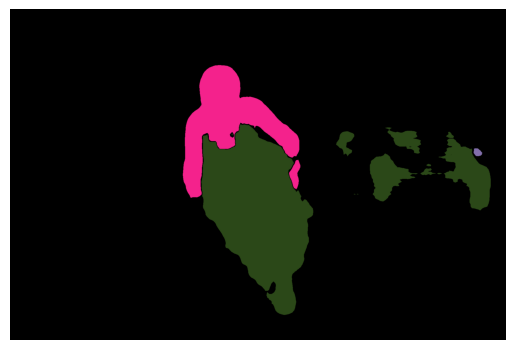

In [5]:
weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
model = torchvision.models.segmentation.deeplabv3_resnet50(weights=weights)
model.eval().to(device)
image=transform(image_pil).to(device).unsqueeze(0)
outputs=get_segment_labels(image,model)
normalized_masks=outputs.softmax(dim=1)

class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
print(class_to_idx)
# Classes of interest for Test4_1.jpg
classes_of_interest = ["motorbike", "car", "person"]

# Classes of interest for Test4_2.jpg
# classes_of_interest = ["motorbike", "car","bus" ,"person"]

# Classes of interest for Test4_3.jpg
# classes_of_interest = ["bus", "car" ]

class_masks = {}

for cls in classes_of_interest:
    class_idx = class_to_idx[cls]

    # Fetch the mask for the class
    class_masks[cls] = (normalized_masks[0, class_idx] > 0.5).detach().cpu().numpy()

display_and_save_segmented_image(class_masks,image,"test4_1")

{'__background__': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}


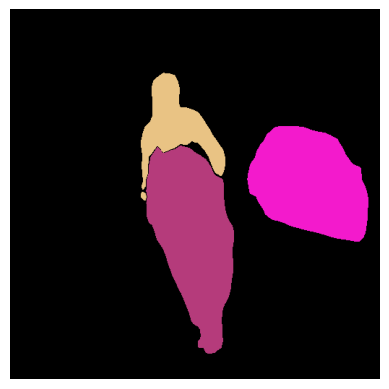

In [7]:
weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
model = torchvision.models.segmentation.deeplabv3_resnet50(weights=weights)
model.eval().to(device)
image=transform(image_pil).to(device).unsqueeze(0)
outputs=get_segment_labels(image,model)
normalized_masks=outputs.softmax(dim=1)

class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
print(class_to_idx)
# Classes of interest for Test4_1.jpg 512x512
classes_of_interest = ["motorbike", "car", "person"]

# Classes of interest for Test4_2.jpg
# classes_of_interest = ["motorbike", "car","bus" ,"person"]

# Classes of interest for Test4_3.jpg
# classes_of_interest = ["bus", "car" ]

class_masks = {}

for cls in classes_of_interest:
    class_idx = class_to_idx[cls]

    # Fetch the mask for the class
    class_masks[cls] = (normalized_masks[0, class_idx] > 0.5).detach().cpu().numpy()

display_and_save_segmented_image(class_masks,image,"test4_1_512")

{'__background__': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}


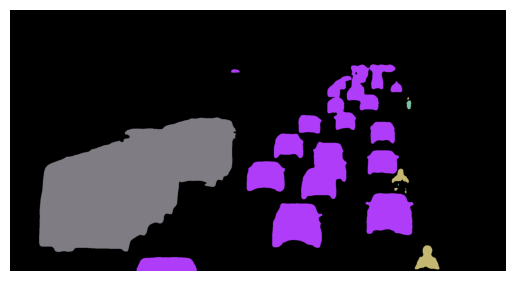

In [16]:
weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
model = torchvision.models.segmentation.deeplabv3_resnet50(weights=weights)
model.eval().to(device)
image=transform(image_pil).to(device).unsqueeze(0)
outputs=get_segment_labels(image,model)
normalized_masks=outputs.softmax(dim=1)

class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
print(class_to_idx)
# Classes of interest for Test4_1.jpg
# classes_of_interest = ["motorbike", "car", "person"]

# Classes of interest for Test4_2.jpg
classes_of_interest = ["motorbike", "car","bus" ,"person"]

# Classes of interest for Test4_3.jpg
# classes_of_interest = ["bus", "car" ]

class_masks = {}

for cls in classes_of_interest:
    class_idx = class_to_idx[cls]

    # Fetch the mask for the class
    class_masks[cls] = (normalized_masks[0, class_idx] > 0.5).detach().cpu().numpy()

display_and_save_segmented_image(class_masks,image,"test4_2")

{'__background__': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}


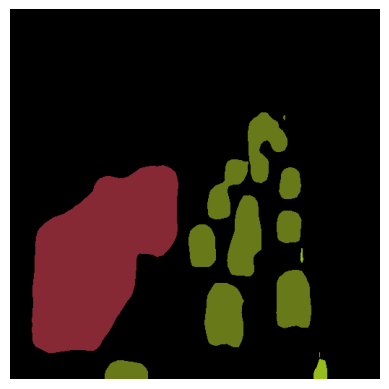

In [18]:
weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
model = torchvision.models.segmentation.deeplabv3_resnet50(weights=weights)
model.eval().to(device)
image=transform(image_pil).to(device).unsqueeze(0)
outputs=get_segment_labels(image,model)
normalized_masks=outputs.softmax(dim=1)

class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
print(class_to_idx)
# Classes of interest for Test4_1.jpg
# classes_of_interest = ["motorbike", "car", "person"]

# Classes of interest for Test4_2.jpg 512x512
classes_of_interest = ["motorbike", "car","bus" ,"person"]

# Classes of interest for Test4_3.jpg
# classes_of_interest = ["bus", "car" ]

class_masks = {}

for cls in classes_of_interest:
    class_idx = class_to_idx[cls]

    # Fetch the mask for the class
    class_masks[cls] = (normalized_masks[0, class_idx] > 0.5).detach().cpu().numpy()

display_and_save_segmented_image(class_masks,image,"test4_2_512")

{'__background__': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}


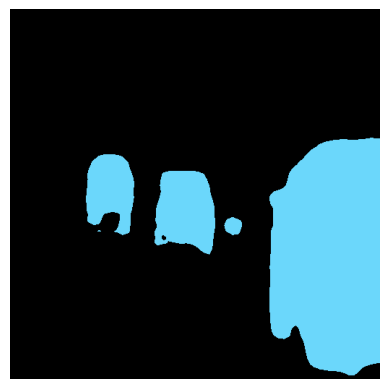

In [21]:
weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
model = torchvision.models.segmentation.deeplabv3_resnet50(weights=weights)
model.eval().to(device)
image=transform(image_pil).to(device).unsqueeze(0)
outputs=get_segment_labels(image,model)
normalized_masks=outputs.softmax(dim=1)

class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
print(class_to_idx)
# Classes of interest for Test4_1.jpg
# classes_of_interest = ["motorbike", "car", "person"]

# Classes of interest for Test4_2.jpg 512x512
# classes_of_interest = ["motorbike", "car","bus" ,"person"]

# Classes of interest for Test4_3.jpg
classes_of_interest = ["bus", "car"]

class_masks = {}

for cls in classes_of_interest:
    class_idx = class_to_idx[cls]

    # Fetch the mask for the class
    class_masks[cls] = (normalized_masks[0, class_idx] > 0.5).detach().cpu().numpy()

display_and_save_segmented_image(class_masks,image,"test4_3_512")

{'__background__': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}


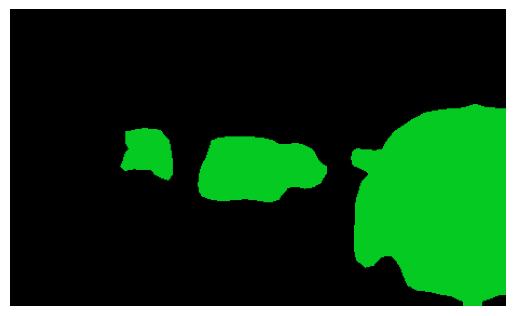

In [23]:
weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
model = torchvision.models.segmentation.deeplabv3_resnet50(weights=weights)
model.eval().to(device)
image=transform(image_pil).to(device).unsqueeze(0)
outputs=get_segment_labels(image,model)
normalized_masks=outputs.softmax(dim=1)

class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}
print(class_to_idx)
# Classes of interest for Test4_1.jpg
# classes_of_interest = ["motorbike", "car", "person"]

# Classes of interest for Test4_2.jpg 512x512
# classes_of_interest = ["motorbike", "car","bus" ,"person"]

# Classes of interest for Test4_3.jpg
classes_of_interest = ["bus", "car"]

class_masks = {}

for cls in classes_of_interest:
    class_idx = class_to_idx[cls]

    # Fetch the mask for the class
    class_masks[cls] = (normalized_masks[0, class_idx] > 0.5).detach().cpu().numpy()

display_and_save_segmented_image(class_masks,image,"test4_3")